In [ ]:
#pip install -r requirements.txt

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet('./yellow_tripdata_2022-01.parquet')

df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [25]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0,17.816667
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0,8.400000
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0,8.966667
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0,10.033333
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0,37.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN,5.966667
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN,10.650000
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN,11.000000
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN,12.050000


In [26]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
count,2.421440e+06,2421440,2421440,2.354481e+06,2.421440e+06,2.354481e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.421440e+06,2.354481e+06,2.354481e+06,2.421440e+06
mean,1.700020e+00,2022-01-17 01:35:16.982017792,2022-01-17 01:47:57.258748160,1.389813e+00,5.374377e+00,1.359217e+00,1.189319e+00,1.266161e+01,1.014453e+00,4.940617e-01,2.371678e+00,3.636815e-01,2.974866e-01,1.888460e+01,2.301668e+00,8.057827e-02,1.267128e+01
min,1.000000e+00,2008-12-31 23:03:01,2008-12-31 23:06:56,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-3.350000e+02,-4.500000e+00,-5.000000e-01,-1.252200e+02,-3.140000e+01,-3.000000e-01,-2.533000e+02,-2.500000e+00,-1.250000e+00,1.000000e+00
25%,1.000000e+00,2022-01-09 15:35:25,2022-01-09 15:47:44,1.000000e+00,1.060000e+00,1.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,0.000000e+00,6.433333e+00
50%,2.000000e+00,2022-01-17 11:58:39.500000,2022-01-17 12:09:32.500000,1.000000e+00,1.760000e+00,1.000000e+00,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,3.000000e-01,1.463000e+01,2.500000e+00,0.000000e+00,1.023333e+01
75%,2.000000e+00,2022-01-24 13:30:43.500000,2022-01-24 13:43:12.500000,1.000000e+00,3.120000e+00,1.000000e+00,1.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,3.000000e+00,0.000000e+00,3.000000e-01,1.980000e+01,2.500000e+00,0.000000e+00,1.613333e+01
max,6.000000e+00,2022-05-18 20:41:57,2022-05-18 20:47:45,9.000000e+00,3.061593e+05,9.900000e+01,5.000000e+00,4.010923e+05,3.350000e+01,3.300000e+00,8.888800e+02,1.933000e+02,3.000000e-01,4.010956e+05,2.500000e+00,1.250000e+00,6.000000e+01
std,4.705126e-01,NaN,NaN,9.836160e-01,5.524458e+02,5.585660e+00,4.876703e-01,2.579900e+02,1.234236e+00,7.060493e-02,2.697403e+00,1.637246e+00,3.859704e-02,2.581265e+02,7.097402e-01,3.084765e-01,8.999282e+00


In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

6.988693785895941

/tmp/ipykernel_154060/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_154060/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


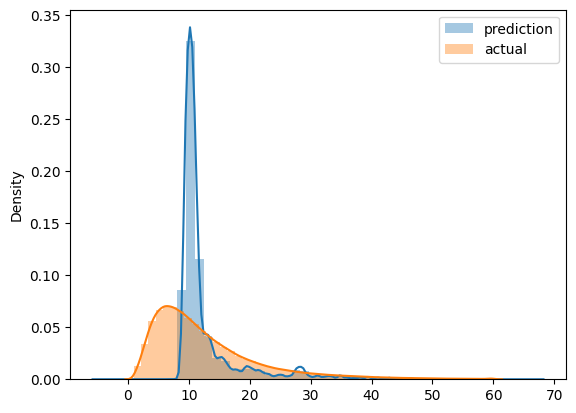

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [14]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_train = read_dataframe('./yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./yellow_tripdata_2022-02.parquet')

In [16]:
len(df_train), len(df_val)

(2421440, 2918187)

In [17]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [18]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.530326016647839

In [21]:
model = Lasso(0.01)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.374921127169834

In [22]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.436622948055644

/tmp/ipykernel_154060/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_154060/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


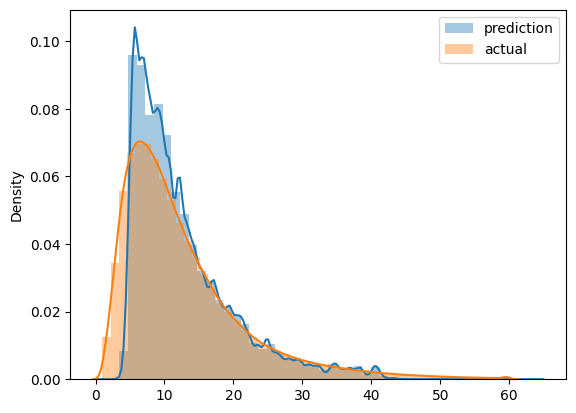

In [23]:
# Graph corresponds to Ridge since it was the last executed model

sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [24]:
with open('nyctaxi_tripduration_ridge.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)